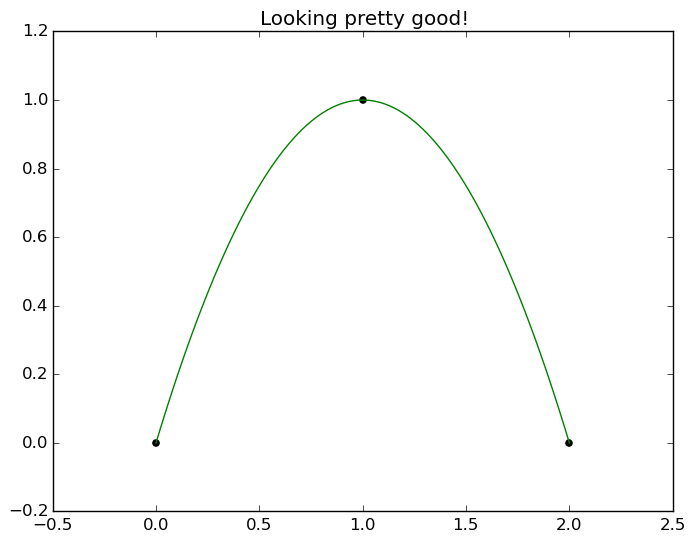

In [2]:
###### Let's begin with a simple example, with no jerk optimization: ######
# Easiest case: pointwise constraints:
xpts = [0,1,2];
ypts = [0,1,0];

# Let's fit a quadratic:
N=3;
x_coeff = zeros(3);
y_coeff = zeros(3);

# Assume the time vector:
T = [0,1,2];

# Form the constraints:
A = [1 T[1] T[1]^2;
     1 T[2] T[2]^2;
     1 T[3] T[3]^2];

# Now we solve the equation A*coeff = constr 
x_coeff = A\xpts;
y_coeff = A\ypts;


# Let's plot the result:
tvals= linspace(0,2,100);
xpoly = zeros(size(tvals,1))
ypoly = zeros(size(tvals,1))

t_ind = 0;
for t in tvals
    t_ind+=1;
    t_vec = [1;t;t^2];
    xpoly[t_ind] = (x_coeff'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly[t_ind] = (y_coeff'*t_vec)[1];   # we access the first element so that the type is Float64
end

using PyPlot;
figure(1); clf();
scatter(xpts,ypts,color=:black)
plot(xpoly,ypoly,color=:green)
title("Looking pretty good!");


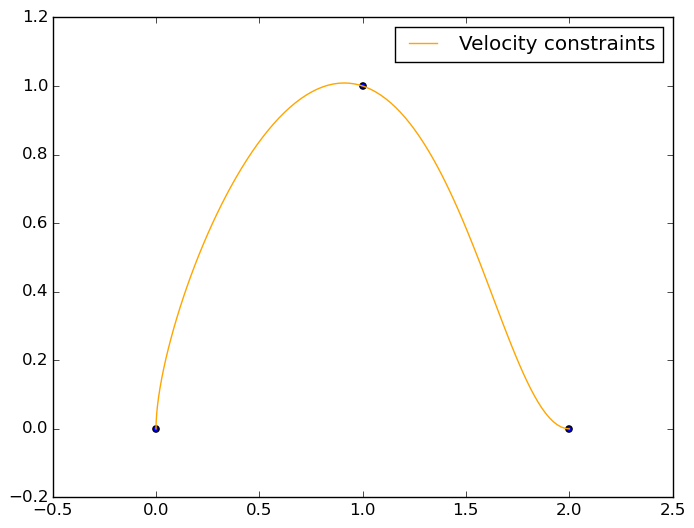

In [5]:

### Now let's add derivative constraints:
vx = [0,1]; # Correspond to initial and final times
vy = [1,0];

# We need to be less lazy about computing A now. This is a function which returns a row vector corresponding to a constraint of given order at the given time.
function constr_order( order, time, degree)
    if(order==0) 
        row_vec = ones(1,degree); 
        for n=2:degree
            row_vec[1,n] = time^(n-1);
        end
        return row_vec;
    end
    row_vec = zeros(1,degree);
    for n = order:degree-1
        coeff = 1; 
        for k=1:order
            coeff = coeff*(n+1-k)
        end

        row_vec[1,n+1] = coeff * (time^(n-order))
    end
    return row_vec;
end

# We need a new polynomial with 3+2 degree:
N = 5;
T = [0,1,2];
xpts = [0,1,2];
ypts = [0,1,0];

# Form the constraints matrix:
A = [constr_order(0,T[1],N);
     constr_order(0,T[2],N);
     constr_order(0,T[3],N);
     constr_order(1,T[1],N);
     constr_order(1,T[3],N)];

# Form the vector of constraint values:
x_B = [xpts; vx];
y_B = [ypts; vy];

# Solve the system:
x_coeff = A\x_B;
y_coeff = A\y_B;

# Plot the result:
t_ind = 0;
for t in tvals
    t_ind+=1;
    t_vec = [1;t;t^2;t^3;t^4];
    xpoly[t_ind] = (x_coeff'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly[t_ind] = (y_coeff'*t_vec)[1];   # we access the first element so that the type is Float64
end
scatter(xpts,ypts)
plot(xpoly,ypoly,color=:orange);
legend(["Velocity constraints"]);


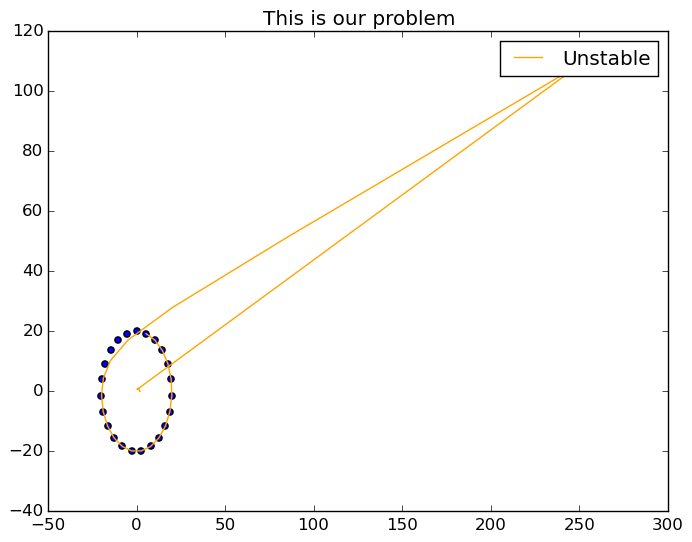

In [6]:
## Just for kicks, let's consider an example that goes very badly. 
num_pts = 23;
xpts = 20*sin(2*pi/num_pts*(1:num_pts));
ypts = 20*cos(2*pi/num_pts*(1:num_pts));
times = collect(0:num_pts-1)

# Now we try to form the A matrix:
A = zeros(0,num_pts);
for n = 1:num_pts
    A = [A; constr_order(0,times[n], num_pts)];
end
x_coeff = A\xpts;
y_coeff = A\ypts;
# Plot the result:
t_ind = 0;
for t in times
    t_ind+=1;
    t_vec = ones(num_pts);
    for k=2:num_pts
       t_vec[k] = t_vec[k-1]*t;
    end
    xpoly[t_ind] = (x_coeff'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly[t_ind] = (y_coeff'*t_vec)[1];   # we access the first element so that the type is Float64
end
figure(2);clf();
scatter(xpts, ypts);
plot(xpoly,ypoly,color=:orange);
legend(["Unstable"])
title("This is our problem");


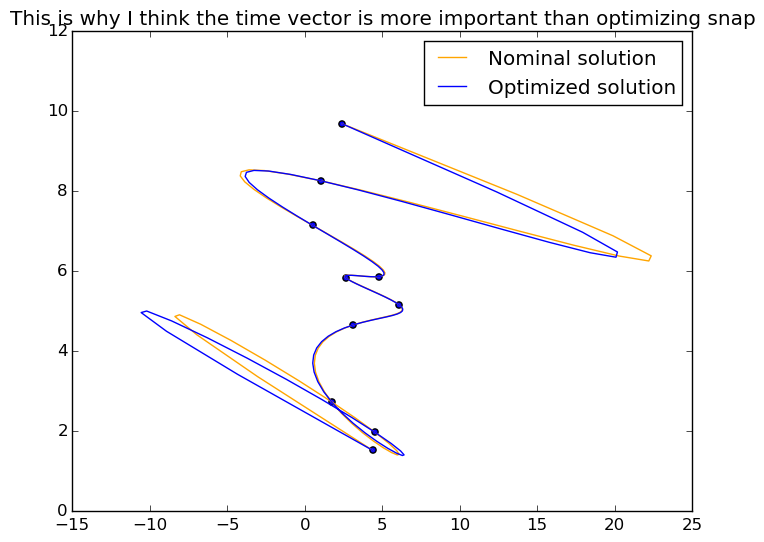

PyObject <matplotlib.text.Text object at 0x7eff1fdf9810>

In [11]:
using PyPlot;
# Let's consider a more difficult example and try optimizing the snap
num_pts = 10;
xpts = num_pts*rand(num_pts);
ypts = num_pts*rand(num_pts);
sort!(ypts);
times = collect(1:num_pts)
degree = num_pts+1 # Add a degree of freedom


# We need to be less lazy about computing A now. This is a function which returns a row vector corresponding to a constraint of given order at the given time.
function constr_order( order, time, degree)
    if(order==0) 
        row_vec = ones(1,degree); 
        for n=2:degree
            row_vec[1,n] = time^(n-1);
        end
        return row_vec;
    end
    row_vec = zeros(1,degree);
    for n = order:degree-1
        coeff = 1; 
        for k=1:order
            coeff = coeff*(n+1-k)
        end

        row_vec[1,n+1] = coeff * (time^(n-order))
    end
    return row_vec;
end
A = zeros(0,degree-1)
for n=1:num_pts
    A = [A; constr_order(0,times[n],degree-1)];
end

# Now we add a dummy constraint?
A_opt = zeros(0,degree)
for n=1:num_pts
    A_opt = [A_opt; constr_order(0,times[n],degree)];
end
A_opt = [A_opt; constr_order(1,times[1],degree)]

# Now we add a dummy constraint?


# To optimize for snap, we weight the 5th component:
q_coeffs = zeros(degree);
q_coeffs[5] = 1.0;


function form_Q(Q_coeffs, t)
    degree = size(Q_coeffs,1)
    Q_mat = zeros(degree,degree)

    for k = 0:degree-1
        if(Q_coeffs[k+1] == 0)
            continue;
        end
        c_k = Q_coeffs[k+1];
        for i=1:degree
        # Form Q
            for l = 1:degree
                if(i >= k && l >= k)                                                   
                    c_tmp = 2*c_k
                    for m = 0:k-1 
                        c_tmp = c_tmp * (i-m)*(l-m);
                    end                                                                
                    Q_mat[i,l] += c_tmp*(t^(i+l-2*k+1))/(i+l-2*k+1)                    
                end
            # Else 0
            end
        end
    end 
    return Q_mat                                                                       
end

# Our cost function:
Q_mat = form_Q(q_coeffs, times[end])                                                   

# Compute R = A^-T Q A^-1                                                              
# This is bad practice, but easy:                                                      
Ainv = inv(A_opt);
R = (Ainv')*(Q_mat*Ainv)

opt_mat = - R[1:degree-1,degree]./R[end,end];                                          
# Now we can back out the polynomials:
x_opt = A_opt\[xpts;opt_mat'*xpts];                                                    
y_opt = A_opt\[ypts;opt_mat'*ypts];                                                    
x_nom = A\xpts;                                                                        
y_nom = A\ypts;

# Plot to see how we did:
t_ind = 0;  
tvals =linspace(times[1],times[end],100);
xpoly_nom = zeros(size(tvals,1));                                                      
ypoly_nom = zeros(size(tvals,1));                                                      
xpoly_opt = zeros(size(tvals,1));                                                      
ypoly_opt = zeros(size(tvals,1));                                                      

for t in tvals
    t_ind+=1;   
    t_vec = ones(num_pts);
    for k=2:num_pts
       t_vec[k] = t_vec[k-1]*t;  
    end     
    xpoly_nom[t_ind] = (x_nom'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly_nom[t_ind] = (y_nom'*t_vec)[1];   # we access the first element so that the type is Float64
    t_vec = ones(num_pts+1);
    for k=2:num_pts+1
       t_vec[k] = t_vec[k-1]*t;                                                        
    end 
    xpoly_opt[t_ind] = (x_opt'*t_vec)[1];   # A note here: x_coeff'*t_vec returns a 1 element array
    ypoly_opt[t_ind] = (y_opt'*t_vec)[1];   # we access the first element so that the type is Float64
end
figure(2);clf();
scatter(xpts, ypts);
plot(xpoly_nom,ypoly_nom,color=:orange);
plot(xpoly_opt,ypoly_opt,color=:blue);
legend(["Nominal solution", "Optimized solution"])                                     
title("This is why I think the time vector is more important than optimizing snap")   